Thêm thư viện

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)
import joblib
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns


Xử lý dữ liệu

In [2]:
# Load dữ liệu
data=pd.read_csv("bank-full.csv",delimiter=';')

print("Số thuộc tính: ",len(data.columns))
n=len(data.columns)
print(data)

# Lấy danh sách các cột categorical
categorical_cols = data.select_dtypes(include=['object']).columns

# Lặp qua các cột categorical và in số lượng giá trị khác nhau
for col in categorical_cols:
    print(f"Thuộc tính '{col}':")
    value_counts = data[col].value_counts()
    for value, count in value_counts.items():
        print(f"  {value}: {count}")
    print()


# In tên thuộc tính
ds_thuoctinh = list(data.iloc[:,0:n-1].columns)
print("Các thuộc tính của tập dữ liệu: ",ds_thuoctinh)

cac_nhan=list(np.unique(data.iloc[:,-1:]))
print("Cột nhãn: ",list(data.iloc[:,-1:].columns))
print("Các nhãn: ",cac_nhan)

# Điếm giá trị của cột nhãn
print(data.iloc[:,-1:].value_counts())

# Giá trị thiếu
print("Missing value:")
print((data[ds_thuoctinh]=='').sum())

#Tiền xử lý dữ liệu
list_dt = []
le = preprocessing.LabelEncoder()


for (columnName, columnData) in data.iloc[:,0:n-1].items():
    # Kiểm tra nếu dữ liệu không phải là số
    if not pd.to_numeric(columnData, errors='coerce').notnull().all():
        le.fit(list(data[columnName]))
        nhan_cot = set(list(data[columnName]))
        data[columnName] = le.transform(list(data[columnName]))
        dic_dt = {}
        for i in nhan_cot:
            dic_dt[i] = int(le.transform([i])[0])
        list_dt.append(dic_dt)
    else:
        list_dt.append({})  # Thêm một từ điển trống nếu dữ liệu là số

X_data = data.iloc[:,0:n-1]
y_target = data.iloc[:,-1:]

for i in range(len(list_dt)):
    print(ds_thuoctinh[i])
    print(list_dt[i])

print(data)

# save the results to a new file
data.to_csv('bank_numbered.csv', index=False)


# Chuẩn hóa ALL
# Chọn cột kiểu số để chuẩn hóa
numeric_cols = data.select_dtypes(include=['int']).columns

# Danh sách các cột số cần chuẩn hóa
print(numeric_cols)
# # Hiển thị thống kê mô tả các thuộc tính số
# print(car_ev.describe())

scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


# save the results to a new file
data.to_csv('bank_standardized.csv', index=False)

print(data)

Số thuộc tính:  17
       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  dur

Load dữ liệu tập đã được xử lý

In [3]:
import numpy as np
import csv
from imblearn.over_sampling import SMOTE

# Load the dataset
def loadData(path):
    with open(path, "r") as f:
        data = csv.reader(f)
        data = np.array(list(data))
        data = np.delete(data, 0, 0)
        np.random.shuffle(data)
    return data

dulieuLoad = loadData("bank_standardized.csv")

# Tách features và target
X = dulieuLoad[:, :-1].astype(np.float64)
y = dulieuLoad[:, -1]

# SMOTE
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y)

y_resampled[y_resampled == 'yes'] = 1
y_resampled[y_resampled == 'no'] = 0
y_resampled = y_resampled.astype(int)

# Ghép features và target lại
dulieuLoad_resampled = np.column_stack((X_resampled, y_resampled))


# Tạo danh sách tên cột
columns = ['age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','y']

# Tạo DataFrame từ dữ liệu resampled và danh sách tên cột
df = pd.DataFrame(dulieuLoad_resampled, columns=columns)

# Lưu dữ liệu resampled vào file CSV
df.to_csv('x_resampled.csv', index=False)

print("Số dòng của tập dữ liệu sau khi resampled:", len(dulieuLoad_resampled))

num_yes = np.sum(y_resampled == 1)
num_no = np.sum(y_resampled == 0)

if num_yes == num_no:
    print("Số lượng 'yes' và 'no' sau khi resampled là bằng nhau.")
else:
    print("Số lượng 'yes' và 'no' sau khi resampled không bằng nhau.")


Số dòng của tập dữ liệu sau khi resampled: 79844
Số lượng 'yes' và 'no' sau khi resampled là bằng nhau.


Huấn luyện Gauss 10 lần

Acc=74.80743941386436, Prec=76.8172773886486, Recall=74.80743941386436, F1=74.33418544409844
Độ chính xác trên tập huấn luyện: 74.9208102580275
Độ chính xác trên tập kiểm tra: 74.33418544409844


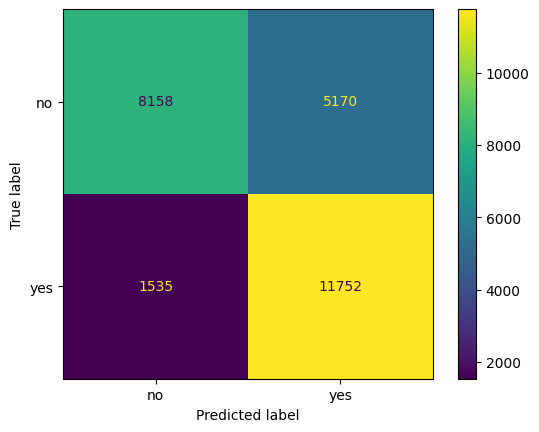

In [4]:
import random
import statistics


X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_resampled, y_resampled, test_size=1/3, random_state=42)

model = GaussianNB()
model.fit(X_Train, Y_Train)

Y_Pred_train = model.predict(X_Train)
Y_Pred = model.predict(X_Test)

Ketqua_accuracy = accuracy_score(Y_Test, Y_Pred)*100
Ketqua_precision = precision_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_recall = recall_score(Y_Test, Y_Pred, average='weighted')*100

Ketqua_f1 = f1_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_f1_train = f1_score(Y_Train, Y_Pred_train, average='weighted') * 100



joblib.dump(model, 'model_bayes.pkl')


print("Acc={}, Prec={}, Recall={}, F1={}".format(Ketqua_accuracy, Ketqua_precision, Ketqua_recall, Ketqua_f1))

print("Độ chính xác trên tập huấn luyện:",Ketqua_f1_train )
print("Độ chính xác trên tập kiểm tra:",Ketqua_f1 )

# Hiển thị confusion matrix
best_conf_matrix = confusion_matrix(Y_Test, Y_Pred)


disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix, display_labels=cac_nhan)
disp.plot()


Huấn luyện Decision Tree 10 lần

Acc=87.2365207589705, Prec=87.24043700350525, Recall=87.2365207589705, F1=87.23630028323862
Độ chính xác trên tập huấn luyện: 88.41562772718426
Độ chính xác trên tập kiểm tra: 87.23630028323862


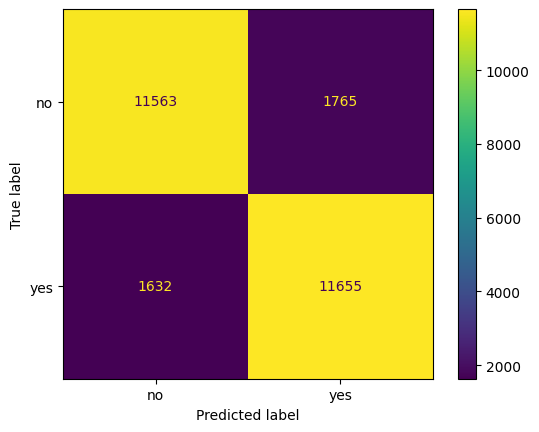

In [5]:

import random
import statistics


X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_resampled, y_resampled, test_size=1/3, random_state=42)

model = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=10, min_samples_split=100, min_samples_leaf=10, max_features=16)
model.fit(X_Train, Y_Train)

Y_Pred_train = model.predict(X_Train)
Y_Pred = model.predict(X_Test)

Ketqua_accuracy = accuracy_score(Y_Test, Y_Pred)*100
Ketqua_precision = precision_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_recall = recall_score(Y_Test, Y_Pred, average='weighted')*100

Ketqua_f1 = f1_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_f1_train = f1_score(Y_Train, Y_Pred_train, average='weighted') * 100



joblib.dump(model, 'model_dt.pkl')


print("Acc={}, Prec={}, Recall={}, F1={}".format(Ketqua_accuracy, Ketqua_precision, Ketqua_recall, Ketqua_f1))

print("Độ chính xác trên tập huấn luyện:",Ketqua_f1_train )
print("Độ chính xác trên tập kiểm tra:",Ketqua_f1 )

# Hiển thị confusion matrix
best_conf_matrix = confusion_matrix(Y_Test, Y_Pred)


disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix, display_labels=cac_nhan)
disp.plot()


Huấn luyện Random Forest 10 lần

Acc=87.7662972008266, Prec=87.95213261350203, Recall=87.7662972008266, F1=87.75206542098033
Độ chính xác trên tập huấn luyện: 88.44790854609334
Độ chính xác trên tập kiểm tra: 87.75206542098033


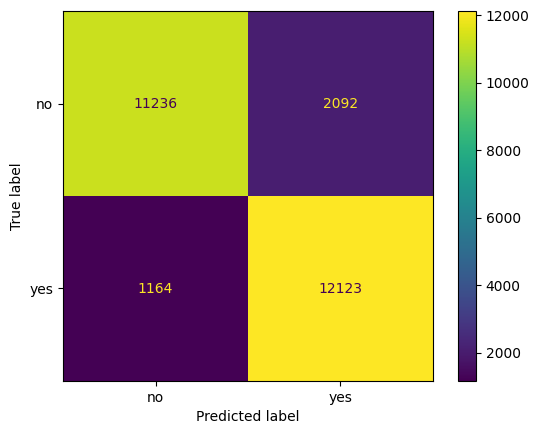

In [6]:


import random
import statistics


X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_resampled, y_resampled, test_size=1/3, random_state=42)


model = RandomForestClassifier(n_estimators=500,
                                criterion='gini',
                                bootstrap=True,
                                max_samples=800)
model.fit(X_Train, Y_Train)

Y_Pred_train = model.predict(X_Train)
Y_Pred = model.predict(X_Test)

Ketqua_accuracy = accuracy_score(Y_Test, Y_Pred)*100
Ketqua_precision = precision_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_recall = recall_score(Y_Test, Y_Pred, average='weighted')*100

Ketqua_f1 = f1_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_f1_train = f1_score(Y_Train, Y_Pred_train, average='weighted') * 100



joblib.dump(model, 'model_rf.pkl')


print("Acc={}, Prec={}, Recall={}, F1={}".format(Ketqua_accuracy, Ketqua_precision, Ketqua_recall, Ketqua_f1))

print("Độ chính xác trên tập huấn luyện:",Ketqua_f1_train )
print("Độ chính xác trên tập kiểm tra:",Ketqua_f1 )

# Hiển thị confusion matrix
best_conf_matrix = confusion_matrix(Y_Test, Y_Pred)


disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix, display_labels=cac_nhan)
disp.plot()


Huấn luyện Bagging 10 lần

Acc=88.04057862107834, Prec=88.12337491252109, Recall=88.04057862107834, F1=88.03457562120636
Độ chính xác trên tập huấn luyện: 88.9139364224428
Độ chính xác trên tập kiểm tra: 88.03457562120636


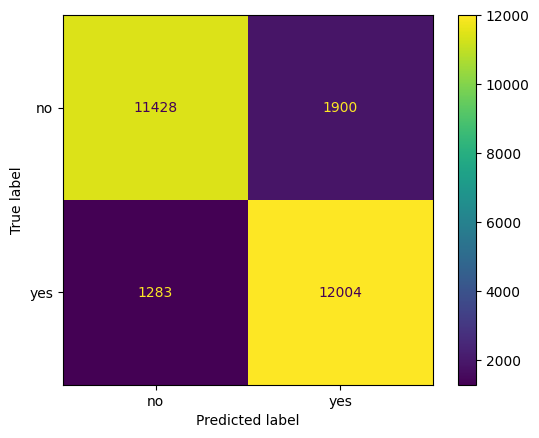

In [7]:

import random
import statistics


X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_resampled, y_resampled, test_size=1/3, random_state=42)

model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=10, random_state=42), 
                          n_estimators=10, max_samples=0.7, random_state=42)


model.fit(X_Train, Y_Train)

Y_Pred_train = model.predict(X_Train)
Y_Pred = model.predict(X_Test)

Ketqua_accuracy = accuracy_score(Y_Test, Y_Pred)*100
Ketqua_precision = precision_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_recall = recall_score(Y_Test, Y_Pred, average='weighted')*100

Ketqua_f1 = f1_score(Y_Test, Y_Pred, average='weighted')*100
Ketqua_f1_train = f1_score(Y_Train, Y_Pred_train, average='weighted') * 100



joblib.dump(model, 'model_bagging.pkl')


print("Acc={}, Prec={}, Recall={}, F1={}".format(Ketqua_accuracy, Ketqua_precision, Ketqua_recall, Ketqua_f1))

print("Độ chính xác trên tập huấn luyện:",Ketqua_f1_train )
print("Độ chính xác trên tập kiểm tra:",Ketqua_f1 )

# Hiển thị confusion matrix
best_conf_matrix = confusion_matrix(Y_Test, Y_Pred)


disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix, display_labels=cac_nhan)
disp.plot()
